# 2D Diffusion

In this tutorial, we extend the diffusion modeling to two spatial dimensions. This involves storing variables in a numpy array with two spatial dimensions, e.g., `c.shape = (n_x, n_y, n_c)`, where `n_x` and `n_y` are the number of grid points in the x and y directions, respectively, and `n_c` is the number of components.

The `PyMRM` library allows defining gradient and divergence matrices for each axis independently by specifying the `axis` argument. This flexibility makes it straightforward to handle multidimensional problems.

We will demonstrate how to set up and solve a 2D diffusion problem, including defining boundary conditions, constructing gradient and divergence operators, and visualizing the results.

<a id='2d-diffusion-example'></a>
## 2D Diffusion Example

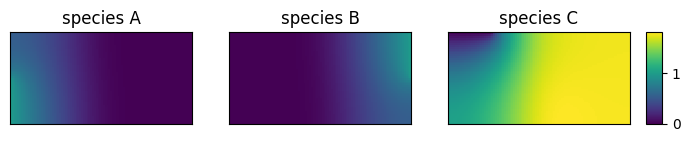

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pymrm import NumJac, newton, construct_coefficient_matrix, construct_grad, construct_div

# Physical parameters
num_c = 3  # Number of components
L = (2.0, 1.0)  # Dimensions of the domain (x, y)
D = [[1.0, 1.0, 0.5]]  # Diffusion coefficients for each component
k = 500  # Reaction rate constant

# Boundary conditions for the left and right boundaries:
bc_L = {'a': [[[0, 1, 1]]], 'b': [[[1, 0, 0]]], 'd': [[[1, 0, 0]]]}  # Dirichlet for A, Neumann for B, Neumann for C
bc_R = {'a': [[[1, 0, 1]]], 'b': [[[0, 1, 0]]], 'd': [[[0, 1, 0]]]}  # Neumann for A, Dirichlet for B, Neumann for C

# Boundary conditions for the bottom and upper boundaries:
bc_B = {'a': [[[1, 1, 1]]], 'b': [[[0, 0, 0]]], 'd': [[[0, 0, 0]]]}  # All Neumann
bc_U = {'a': [[[1, 1, 0]]], 'b': [[[0, 0, 1]]], 'd': [[[0, 0, 0]]]}  # Neumann for A and B, Dirichlet for C

# Reaction kinetics
def reaction(c, k):
    """Compute reaction rates for the system."""
    f = np.empty_like(c)  # Initialize reaction term array
    r = k * c[..., 0] * c[..., 1]  # Reaction rate: A + B -> C
    f[..., 0] = -r  # Loss of A
    f[..., 1] = -r  # Loss of B
    f[..., 2] = r   # Gain of C
    return f

# Numerical parameters
dt = np.inf  # Time step size (infinity for steady state)
shape = (100, 50, num_c)  # Shape of the concentration array (x, y, components)

# Grid setup in x and y direction
x_f = np.linspace(0, L[0], shape[0] + 1)  # Face positions in x-direction
x_c = 0.5 * (x_f[:-1] + x_f[1:])  # Cell-centered positions in x-direction
y_f = np.linspace(0, L[1], shape[1] + 1)  # Face positions in y-direction
y_c = 0.5 * (y_f[:-1] + y_f[1:])  # Cell-centered positions in y-direction

# Create accumulation matrix
accum_mat = construct_coefficient_matrix(1/dt, shape=shape)  # Accumulation term matrix

# Discretized gradient and divergence operator in x-direction
grad_x_mat, grad_x_bc = construct_grad(shape, x_f, x_c, bc=(bc_L, bc_R), axis=0)  # Gradient operator
D_x_mat = construct_coefficient_matrix(D, shape=shape, axis=0)  # Diffusion coefficient matrix
div_x_mat = construct_div(shape, x_f, nu=0, axis=0)  # Divergence operator

# Discretized gradient and divergence operator in y-direction
grad_y_mat, grad_y_bc = construct_grad(shape, y_f, y_c, bc=(bc_B, bc_U), axis=1)  # Gradient operator
D_y_mat = construct_coefficient_matrix(D, shape=shape, axis=1)  # Diffusion coefficient matrix
div_y_mat = construct_div(shape, y_f, nu=0, axis=1)  # Divergence operator

# Create a diffusion Jacobian matrix and boundary condition contribution
jac_diff = div_x_mat @ (-D_x_mat @ grad_x_mat) + div_y_mat @ (-D_y_mat @ grad_y_mat)  # Diffusion term
jac_diff_bc = div_x_mat @ (-D_x_mat @ grad_x_bc) + div_y_mat @ (-D_y_mat @ grad_y_bc)  # Boundary condition contribution

numjac = NumJac(shape)  # Numerical Jacobian for reaction terms

def g(c, c_old):
    """Compute the residual and Jacobian of the system of equations."""
    c_vec = c.reshape((-1, 1))  # Flatten concentration array
    c_old_vec = c_old.reshape((-1, 1))  # Flatten old concentration array
    g_react, jac_react = numjac(lambda c: reaction(c, k), c)  # Reaction term and Jacobian
    g = accum_mat @ (c_vec - c_old_vec) + jac_diff @ c_vec + jac_diff_bc - g_react.reshape((-1, 1))  # Residual
    jac = accum_mat + jac_diff - jac_react  # Total Jacobian
    return g, jac

# Initial concentration (all zeros)
c_old = np.zeros(shape)

# Solve the system using Newton's method
result = newton(lambda c: g(c, c_old), c_old, tol=1e-6, maxfev=10)
c = result.x.reshape(shape)  # Reshape solution to original shape

# Visualization
labels = ["A", "B", "C"]  # Labels for species
fig, ax = plt.subplots(1, num_c, figsize=(8, 2))  # Create subplots
contour = [None] * num_c  # Initialize contour plots
c_max = np.max(c)  # Maximum concentration for color scaling
for i in range(num_c):
    ax[i].set_xticks([])  # Remove x-axis ticks
    ax[i].set_yticks([])  # Remove y-axis ticks
    ax[i].set_title(f'species {labels[i]}')  # Set subplot title
    contour[i] = ax[i].pcolormesh(x_f, y_f, c[:, :, i].T, shading='flat', cmap='viridis', vmin=0, vmax=c_max)  # Plot concentration
    ax[i].set_aspect('equal')  # Equal aspect ratio
cbar_ax = fig.add_axes([0.92, ax[0].get_position().y0, 0.02, ax[0].get_position().y1 - ax[0].get_position().y0])  # Colorbar axis
plt.colorbar(contour[0], cax=cbar_ax)  # Add colorbar

plt.show()  # Display the plots

## Position dependent Boundary Conditions

Boundary condition parameters can be arrays. For example, if `c.shape=(n_x, n_y, n_c)`, then the coefficients for the boundary conditions in the x-direction (i.e., `axis=0`) can have the shape `(1, n_y, n_c)`. This means at $x=0$ and $x=L$, you can supply a value for each $y$ position and each component.

Until now, we supplied boundary conditions of the shape `(1,1,n_c)`. Here, the $y$ direction is 'singleton'. In the `PyMRM` implementations, these boundary conditions are 'broadcasted' along `axis=1`. This means the same value is used for every $y$ position.

As an example, let us consider the case where component $A$ is introduced on the left boundary through a hole between `y_L_min` and `y_L_max`, and $B$ is fed on the right between `y_R_min` and `y_R_max`. Component $C$ is removed on the upper boundary between `x_U_min` and `x_U_max`.

You can run the cell below to specify the position-dependent boundary conditions.
Next, in the [cell above](#2d-diffusion-example), comment out the specification of the boundary conditions (so that the new ones are used) and rerun the cell.

In [65]:
# Define the inlet regions for boundary conditions
# Left boundary: A is introduced between y_L_min and y_L_max
y_L_min = 0.00 * L[1]
y_L_max = 0.50 * L[1]

# Right boundary: B is introduced between y_R_min and y_R_max
y_R_min = 0.50 * L[1]
y_R_max = 1.00 * L[1]

# Upper boundary: C is removed between x_U_min and x_U_max
x_U_min = 0.00 * L[0]
x_U_max = 0.25 * L[0]

# Helper function to create a filter for regions
def hole_filter(x, x_min, x_max):
    """Returns a boolean mask for positions within the specified range."""
    fltr = (x >= x_min) & (x < x_max)
    return fltr

# Initialize all positions on the left boundary as Neumann
a_L = np.ones((1,) + shape[1:])  # Coefficient for Neumann condition
b_L = np.zeros((1,) + shape[1:])  # Coefficient for Dirichlet condition
d_L = np.zeros((1,) + shape[1:])  # Dirichlet value

# Apply Dirichlet condition for A in the specified region on the left boundary
fltr = hole_filter(y_c, y_L_min, y_L_max)
a_L[:,fltr,0] = 0  # Switch to Dirichlet for A
b_L[:,fltr,0] = 1  # Set Dirichlet coefficient for A
d_L[:,fltr,0] = 1  # Set Dirichlet value for A
bc_L = {'a':a_L, 'b':b_L, 'd':d_L}

# Initialize all positions on the right boundary as Neumann
a_R = np.ones((1,) + shape[1:])  # Coefficient for Neumann condition
b_R = np.zeros((1,) + shape[1:])  # Coefficient for Dirichlet condition
d_R = np.zeros((1,) + shape[1:])  # Dirichlet value

# Apply Dirichlet condition for B in the specified region on the right boundary
fltr = hole_filter(y_c, y_R_min, y_R_max)
a_R[:,fltr,1] = 0  # Switch to Dirichlet for B
b_R[:,fltr,1] = 1  # Set Dirichlet coefficient for B
d_R[:,fltr,1] = 1  # Set Dirichlet value for B
bc_R = {'a':a_R, 'b':b_R, 'd':d_R}

# All positions on the bottom boundary are Neumann
bc_B = {'a':1, 'b':0, 'd':0}

# Initialize all positions on the upper boundary as Neumann
a_U = np.ones((shape[0], 1, shape[2]))
b_U = np.zeros((shape[0], 1, shape[2]))
d_U = np.zeros((shape[0], 1, shape[2]))

# Apply Dirichlet condition for C in the specified region on the upper boundary
fltr = hole_filter(x_c, x_U_min, x_U_max)
a_U[fltr,:,2] = 0  # Switch to Dirichlet for C
b_U[fltr,:,2] = 1  # Set Dirichlet coefficient for C
d_U[fltr,:,2] = 0  # Set Dirichlet value for C
bc_U = {'a':a_U, 'b':b_U, 'd':d_U}

## Position Dependent Diffusion Coefficient

Diffusion coefficients can also be made position-dependent. However, it is important to note that diffusion coefficients are specified at the face positions of the grid. This means that you need to carefully use the appropriate grid variables (`x_c`, `x_f`, `y_c`, and `y_f`) when defining the coefficients.

Alternatively, you can define diffusion coefficients at cell centers and use `PyMRM` interpolation routines to obtain staggered values at the face positions.

As an example, consider a circular region within the domain where the diffusion coefficient is set to zero. This creates a no-diffusion zone. The code below demonstrates how to define such a region.

### Important Notes:
- For regions with zero diffusion, the stationary state depends on the initial state. For example, if components $A$ and $B$ are present, they will produce a certain amount of $C$ that cannot diffuse away. This means the steady state is not uniquely defined.
- When using `dt=np.inf` (steady-state assumption), the problem becomes singular because it lacks a unique solution. To address this, you can use a large but finite time step (`dt`) and initialize the domain with all concentrations set to zero. This ensures that the concentrations remain zero in the no-diffusion region.

To apply this, run the cell below to provide position dependent diffusion coefficients. Next, comment out the `D_x_mat` and `D_y_mat` in the [2D Diffusion Example](#2d-diffusion-example), provide a large but finite time step `dt`, and rerun the example.

In [ ]:
# Define the center and radius of the circular no-diffusion region
x_cntr = 0.5 * L[0]  # x-coordinate of the center
y_cntr = 0.5 * L[1]  # y-coordinate of the center
R = 0.3 * L[1]  # Radius of the circular region

# Function to create a mask for the circular region
def circle_mask(x, y, x_cntr, y_cntr, R):
    """Returns a boolean mask for positions outside the circular region."""
    return (x.reshape((-1, 1)) - x_cntr)**2 + (y.reshape((1, -1)) - y_cntr)**2 > R**2

# Apply the circular mask to the diffusion coefficients in the x-direction
D_x = circle_mask(x_f, y_c, x_cntr, y_cntr, R)[..., np.newaxis] * np.asarray(D).reshape((1, 1, -1))
D_x_mat = construct_coefficient_matrix(D_x)  # Construct the coefficient matrix for x-direction

# Apply the circular mask to the diffusion coefficients in the y-direction
D_y = circle_mask(x_c, y_f, x_cntr, y_cntr, R)[..., np.newaxis] * np.asarray(D).reshape((1, 1, -1))
D_y_mat = construct_coefficient_matrix(D_y)  # Construct the coefficient matrix for y-direction

## Exercise

- Play around with position dependent boundary conditions and diffusion coefficients.
- Implement a position-dependent reaction rate constant, for example, only make a specific region reactive.
- Implement composition dependent diffusion coefficients, e.g., using a Fick-Wilke mixing law.